# Figure 1: Mean Squared Error as a function of the samples per site and sites

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import matplotlib.colors as colors

import smpsite as smp

%matplotlib inline

/tmp/ipykernel_2595/2142690695.py:4: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


### Figure

In [2]:
df = pd.read_csv('../../outputs/fig1a_10000sim_summary.csv')

# Compute the root of the mean square error
df['error_angle_S'] = df['error_angle_S2'] ** .5
df

,Unnamed: 0,Unnamed: 1,error_angle_mean,error_angle_median,error_angle_25,error_angle_75,error_angle_95,error_angle_std,error_angle_S2,error_vgp_scatter,...,n0,kappa_within_site,site_lat,site_long,outlier_rate,secular_method,kappa_secular,ignore_outliers,total_simulations,error_angle_S
0,0,0,4.147206,3.912595,2.484667,5.486852,8.148171,2.186134,21.978023,3.186314,...,2,50,30.0,0.0,0.0,G,NaN,False,10000,4.688072
1,1,0,4.725067,4.445762,2.876439,6.279026,9.143663,2.455932,28.357256,2.932066,...,27,50,30.0,0.0,0.0,G,NaN,False,10000,5.325153
2,2,0,3.980893,3.739991,2.413162,5.281213,7.779722,2.085578,20.196707,2.438957,...,19,50,30.0,0.0,0.0,G,NaN,False,10000,4.494075
3,3,0,3.233462,3.013762,1.950203,4.281603,6.409835,1.715021,13.396281,5.554613,...,1,50,30.0,0.0,0.0,G,NaN,False,10000,3.660093
4,4,0,2.158836,2.034649,1.311973,2.846312,4.181181,1.125675,5.927591,1.309937,...,8,50,30.0,0.0,0.0,G,NaN,False,10000,2.434664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,754,0,2.649010,2.473473,1.605169,3.503009,5.164014,1.387456,8.942095,1.581143,...,11,50,30.0,0.0,0.0,G,NaN,False,10000,2.990334
755,755,0,2.606820,2.440106,1.561114,3.462770,5.143039,1.368585,8.668347,1.647996,...,5,50,30.0,0.0,0.0,G,NaN,False,10000,2.944206
756,756,0,2.316476,2.175341,1.420605,3.062309,4.489364,1.200979,6.808266,1.450202,...,5,50,30.0,0.0,0.0,G,NaN,False,10000,2.609265
757,757,0,6.289641,5.932100,3.841007,8.335166,12.206067,3.266839,50.230759,4.174381,...,23,50,30.0,0.0,0.0,G,NaN,False,10000,7.087366


We define a function that will make the heatmap. Ideally, we want this to be part of `smpsite` under the plotting tools. However, since each subfigure has quite some level of customization, we leave it like this for now. 

In [3]:
def find_nearest(A, a0):
    """
    Function to round all the values in a generic numpy array A to the closest value in another array n0.
    """
    a = A.flatten()
    idx = ((np.tile(a, (len(a0),1)).T - a0)**2).argmin(axis=1)
    return a0[idx].reshape(A.shape)

In [4]:
def plot_angle_error(df, df_in=None, save_plot=True):
    
    fig, axes = plt.subplots()
    fig.set_size_inches(14, 20)
    # axes.set_aspect("equal")
    
    caxes    = axes.inset_axes([1.04, 0.06, 0.03, 0.4])
    caxes_in = axes.inset_axes([1.04, 0.58, 0.03, 0.4])

    
    def contour_plot(df_, ax, cax, bounds, cmap, cbar_title, make_levels=True, make_contours=True, color_max=16, ticks=None, xmax=40):
    
        X = df_.columns.values
        Y = df_.index.values
        Z = df_.values
        Z_smooth = gaussian_filter(Z, 1.0)
    
        Z = np.clip(Z, a_min=0.0, a_max=color_max)
        # Z_rounded = np.rint(Z)
        mid_points = (bounds[1:] + bounds[:-1]) / 2
        Z_rounded = find_nearest(Z, mid_points)
        Z_rounded[np.isnan(Z)] = 0

        x,y = np.meshgrid(X, Y)

        if make_levels:
            N = x * y
            levels = np.hstack([np.arange(0.0, 100.0, 20), np.arange(100.0, 310, 40.)])
            IsoNLines = ax.contour(x, y, N, 10, colors='white', linestyles="dashed", levels=levels)
            ax.clabel(IsoNLines, inline=True, fontsize=10)

        ColorGrid = ax.pcolormesh(x, y, Z_rounded, cmap=cmap, norm=colors.LogNorm(vmin=2, vmax=color_max), alpha=0.8)
        
        if make_contours:
            ContourLines = ax.contour(x, y, Z, 10, colors='k', levels=bounds)  
            ax.clabel(ContourLines, inline=True, fontsize=14)

        ax.set_xlim([0, 20])
        ax.set_ylim([0, 40])
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_xticks([1,2,3,4,5,6,7,10,15])
        ax.set_yticks(ticks)
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)
    
        cbar = plt.colorbar(ColorGrid, cax=cax, boundaries=bounds, orientation='vertical')#, fraction=0.02, location='right')
        cbar.set_label(cbar_title, rotation=270, fontsize=20, labelpad=20)
     
        return None
    
  
    # Now for the scatter plot
    
    def contour_plot_scatter(df_, ax, cax, bounds, cmap, cbar_title, make_levels=True, make_contours=True, color_max=16):
    
        X = df_.columns.values
        Y = df_.index.values
        Z = df_.values
        Z_smooth = gaussian_filter(Z, 1.0)
    
        Z = np.clip(Z, a_min=0.0, a_max=color_max)
        # Z_rounded = np.rint(Z)
        mid_points = (bounds[1:] + bounds[:-1]) / 2
        Z_rounded = find_nearest(Z, mid_points)
        Z_rounded[np.isnan(Z)] = 0

        x,y = np.meshgrid(X, Y)

        if make_levels:
            N = x * y
            levels = np.hstack([np.arange(0.0, 100.0, 20), np.arange(100.0, 310, 40.)])
            IsoNLines = ax.contour(x, y, N, 10, colors='white', linestyles="dashed", levels=levels)
            ax.clabel(IsoNLines, inline=True, fontsize=10)

        ColorGrid = ax.pcolormesh(x, y, Z_rounded, cmap=cmap, norm=colors.LogNorm(vmin=1, vmax=color_max), alpha=0.8)
        
        if make_contours:
            xmin=1
            ContourLines = ax.contour(x[:,xmin:], y[:, xmin:], Z[:, xmin:], 10, colors='k', levels=bounds)  
            ax.clabel(ContourLines, inline=True, fontsize=14)

        ax.set_xlim([0, 20])
        ax.set_ylim([0, 80])
        ax.set_xlabel('Number of Samples per Site ($n_0$)', fontsize=22)
        ax.set_ylabel('Number of Sites (N)', fontsize=22)
        ax.set_xticks([1,2,3,4,5,6,7,10,15])
        ax.set_yticks([1, 4, 7, 10, 15, 20, 30, 40])
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)
    
        cbar = plt.colorbar(ColorGrid, cax=cax, boundaries=bounds, orientation='vertical')#, fraction=0.02, location='right')
        cbar.set_label(cbar_title, rotation=270, fontsize=20, labelpad=20)
     
        return None

    axin = axes.inset_axes([0.0, 0.54, 1, .5])

    contour_plot_scatter(df_in, 
                     axes, 
                     cax=caxes,
                     bounds=np.hstack([np.arange(0.0, 4.0, 0.5), np.arange(5.0, 12, 2.0)]), 
                     cmap='inferno', 
                     cbar_title="RMSE for VGP scatter (degrees)",
                     make_levels=True, 
                     make_contours=True,
                     color_max=10)

    
    contour_plot(df, 
                 axin, 
                 cax=caxes_in,
                 bounds=np.hstack([np.arange(0.0, 5.0, 0.5), np.arange(5.0, 8, 1.0), np.arange(8.0, 16.0, 2.0)]), 
                 cmap='viridis', 
                 cbar_title="RMSE for pole estimation (degrees)",
                 color_max=14, 
                 ticks=[1, 4, 7, 10, 15, 20, 30, 40])
    
    axes.spines[['right', 'top']].set_visible(False)
    axin.spines[['right', 'top']].set_visible(False)

        
    if save_plot:
        plt.savefig("Figure1.png", dpi=300, format="png", bbox_inches='tight')
        plt.savefig("Figure1.pdf", format="pdf", bbox_inches='tight')
    else: 
        plt.show()

In [5]:
all_kappa = np.unique(df.kappa_within_site.values)

df_filter = df[(df.site_lat==30) 
             & (df.kappa_within_site==50)
             & (df.outlier_rate==0.00) 
             & (df.ignore_outliers==False)]

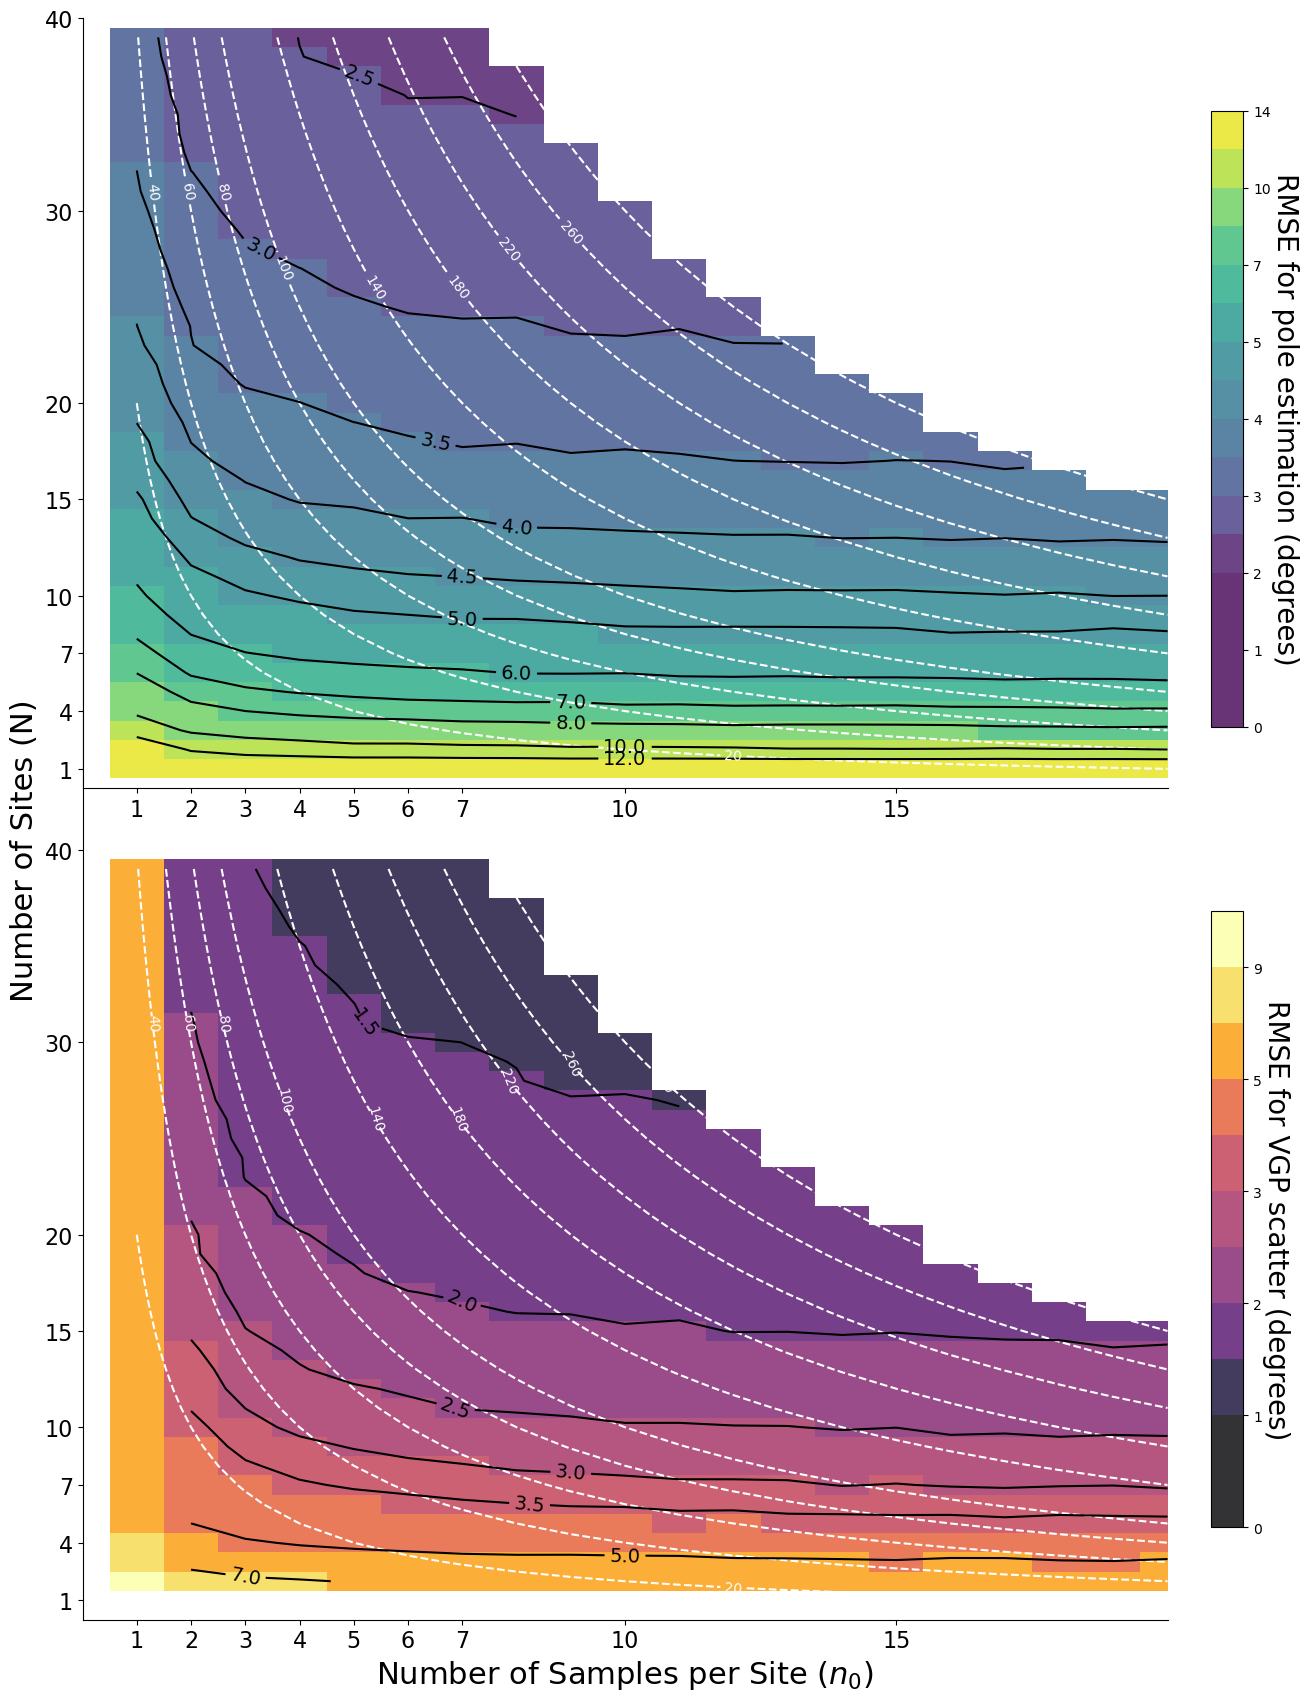

In [6]:
df_pole = df_filter[df_filter.n0 <= 20].pivot('N', 'n0', 'error_angle_S')
df_scatter = df_filter[df_filter.n0 <= 20].pivot('N', 'n0', 'error_vgp_scatter')

plot_angle_error(df_pole, 
                 df_scatter,
                 save_plot=True)

### Theoretical comparision

We can compare this with the theoretical approximations we obtained.

In [7]:
df_filter["error_kappa_theoretical"] = df_filter.apply(lambda row: smp.kappa_theoretical(smp.Params(N=row.N, 
                                                                                                n0=row.n0, 
                                                                                                kappa_within_site=row.kappa_within_site,
                                                                                                site_lat=row.site_lat,
                                                                                                site_long=row.site_long, 
                                                                                                outlier_rate=row.outlier_rate, 
                                                                                                secular_method=row.secular_method, 
                                                                                                kappa_secular=row.kappa_secular)), axis=1)
    
df_filter["error_angle_theoretical"] = df_filter.apply(lambda row: smp.kappa2angular(row.error_kappa_theoretical), axis=1)
df_filter["error_angle_S"] = df_filter["error_angle_S2"] ** .5

df_filter["error_theoretical_relative"] = df_filter.apply(lambda row: (row.error_angle_theoretical-row.error_angle_S) / row.error_angle_S, axis=1)
df_filter[['N', 'n0', 'error_angle_mean', 'error_angle_S', 'error_angle_theoretical', 'error_theoretical_relative']]

,N,n0,error_angle_mean,error_angle_S,error_angle_theoretical,error_theoretical_relative
0,13,2,4.147206,4.688072,4.679167218230616,-0.001900
1,7,27,4.725067,5.325153,5.362703627902144,0.007052
2,10,19,3.980893,4.494075,4.5030198969397155,0.001990
3,29,1,3.233462,3.660093,3.6069201546789595,-0.014528
4,37,8,2.158836,2.434664,2.435654194091217,0.000407
...,...,...,...,...,...,...
754,24,11,2.649010,2.990334,2.9805563914003264,-0.003270
755,27,5,2.606820,2.944206,2.9269658083257255,-0.005856
756,34,5,2.316476,2.609265,2.608296370854666,-0.000371
757,4,23,6.289641,7.087366,7.1190110570614795,0.004465


We can plot the relative error between the theory and the numerical simulation to see that they differ ~1%.

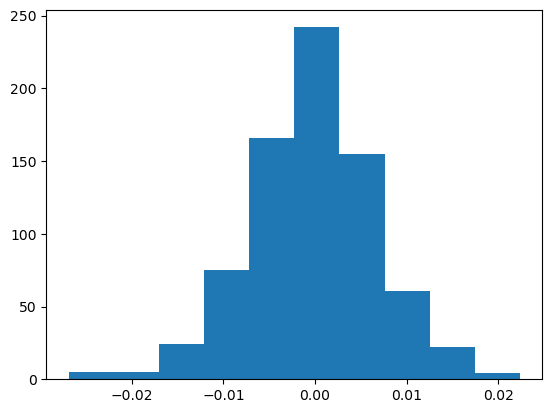

In [8]:
plt.hist(df_filter.error_theoretical_relative);